In [243]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Fetch data
url = "http://127.0.0.1:8000/api/v1/data/?table_name=precios_materiales&limit=1000"
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print(f"✓ Successfully fetched {len(data['data'])} records")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    raise
# Convert to Data Frame
df = pd.DataFrame(data['data'])

#Convert date to date of Dataframe
df['date'] = pd.to_datetime(df['date'])

#Variable a analizar 
var_analizar = 'rebar_mxn'

✓ Successfully fetched 207 records


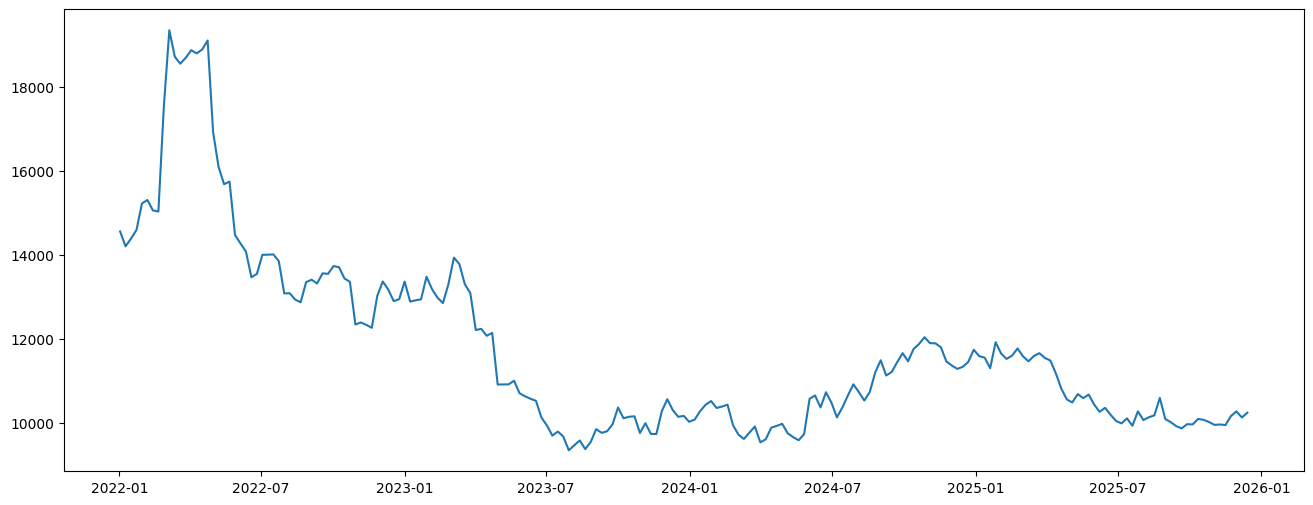

In [240]:
plt.figure(figsize=(16,6))
plt.plot(df['date'], df[var_analizar])

plt.show()


# Modelo LSTM para Pronóstico de Series de Tiempo

Ahora aplicaremos una Red Neuronal LSTM (Long Short-Term Memory) para pronosticar el precio del scrap.


In [287]:
# Importar librerías necesarias para LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM , Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


## Paso 1: Preparar los datos para LSTM

Los datos deben ser:
1. Normalizados (escalados entre 0 y 1)
2. Convertidos a secuencias (ventanas de tiempo)


In [296]:
# Preparar los datos para LSTM
# Convertir la serie a un array numpy y reshape para el scaler
serie = df[[var_analizar]]

dataset = serie.values

data_array = serie.values.reshape(-1, 1)

training_data_len = int(np.ceil( len(data_array) * .95 ))

# Normalizar los datos (escalar entre 0 y 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_array)

print(f"Datos originales - Min: {data_array.min():.2f}, Max: {data_array.max():.2f}")
print(f"Datos escalados - Min: {scaled_data.min():.2f}, Max: {scaled_data.max():.2f}")
print(f"Shape de datos escalados: {scaled_data.shape}")





Datos originales - Min: 9351.92, Max: 19342.95
Datos escalados - Min: 0.00, Max: 1.00
Shape de datos escalados: (207, 1)


In [ ]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)


# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.0894693 , 0.07809039, 0.09271551, 0.08145766, 0.06000566,
       0.06144395, 0.06043854, 0.06715277, 0.07246614, 0.0746489 ,
       0.06157817, 0.06214908, 0.05223518, 0.05739751, 0.06693958,
       0.07444692, 0.12464237, 0.08304403, 0.07871214, 0.07190804,
       0.09276075, 0.0586041 , 0.07589862, 0.06396891, 0.06995879,
       0.08452786, 0.10103668, 0.09157369, 0.1088572 , 0.13260501,
       0.12408086, 0.13383061, 0.11380364, 0.12125733, 0.14676872,
       0.18324296, 0.21364425, 0.21975573, 0.23106989, 0.2246261 ,
       0.2118136 , 0.22374831, 0.24242057, 0.22531822, 0.21747468,
       0.2303047 , 0.25724037, 0.19549095, 0.22037329, 0.22420873,
       0.2393313 , 0.21048041, 0.19881344, 0.19371336, 0.20168551,
       0.21126511, 0.24516754, 0.25461602, 0.25506642, 0.26908701])]
[0.25305711876409076]

[array([0.0894693 , 0.07809039, 0.09271551, 0.08145766, 0.06000566,
       0.06144395, 0.06043854, 0.06715277, 0.07246614, 0.0746489 ,
       0.06157817, 0.06214908, 0.05

In [298]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(2000, return_sequences=False, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
#model.add(LSTM(64, return_sequences=False))
#model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2025-12-22 13:20:02.429172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-12-22 13:20:02.572953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-12-22 13:20:02.712016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


137/137 [==============================] - 18s 110ms/step - loss: 2.7534


In [300]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse


1/1 [==============================] - 0s 29ms/step


1880.5632016979744

In [ ]:
# # Number of months to forecast
# n_future = 12

# # Get last lookback window
# last_window = data_scaled[-60:]
# last_window = last_window.reshape(1, 60, 1)

# future_predictions = []

# for _ in range(n_future):
#     next_pred = model.predict(last_window)
#     future_predictions.append(next_pred[0, 0])

#     last_window = np.append(
#         last_window[:, 1:, :],
#         [[[next_pred[0, 0]]]],
#         axis=1
#     )

# # Inverse scale
# future_predictions = scaler.inverse_transform(
#     np.array(future_predictions).reshape(-1, 1)
# )

# last_date = df['date'].iloc[-1]

# future_dates = pd.date_range(
#     start=last_date,
#     periods=n_future + 1,
#     freq='M'
# )[1:]


# print("Last real date:", df['date'].iloc[-1])
# print("First forecast date:", future_dates[0])

1/1 [==============================] - 0s 21ms/step
Last real date: 2022-01-02 00:00:00
First forecast date: 2022-02-28 00:00:00


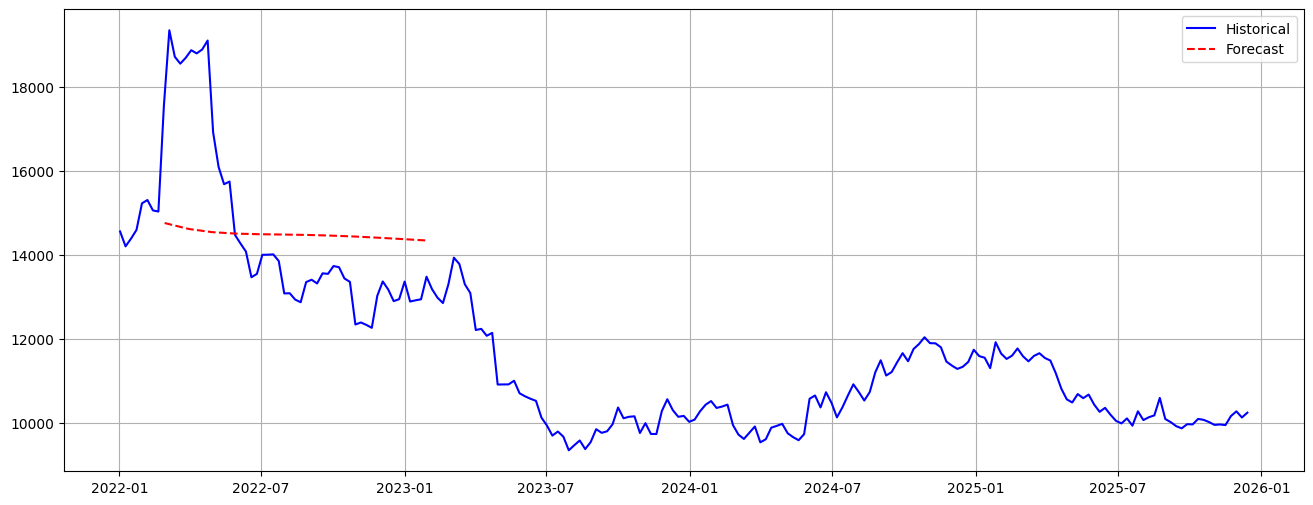

In [ ]:
# plt.figure(figsize=(16,6))
# plt.plot(df['date'], df[var_analizar], label='Historical', color='blue')
# plt.plot(future_dates, future_predictions, '--', label='Forecast', color='red')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# # Create the testing data set
# # Create a new array containing scaled values 
# test_data = scaled_data[training_data_len - 60: , :]
# # Create the data sets x_test and y_test
# x_test = []
# y_test = data_array[training_data_len:, :]
# for i in range(60, len(test_data)):
#     x_test.append(test_data[i-60:i, 0])
    
# # Convert the data to a numpy array
# x_test = np.array(x_test)

# # Reshape the data
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# # Get the models predicted price values 
# predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)


# # Get the root mean squared error (RMSE)
# rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
# rmse

1/1 [==============================] - 0s 18ms/step


3858.424391920789

2025-12-14 00:00:00
[Timestamp('2025-12-21 00:00:00'), Timestamp('2025-12-28 00:00:00'), Timestamp('2026-01-04 00:00:00'), Timestamp('2026-01-11 00:00:00'), Timestamp('2026-01-18 00:00:00'), Timestamp('2026-01-25 00:00:00'), Timestamp('2026-02-01 00:00:00'), Timestamp('2026-02-08 00:00:00'), Timestamp('2026-02-15 00:00:00'), Timestamp('2026-02-22 00:00:00')]
197    17335.187500
198    17611.277344
199    17757.015625
200    17734.310547
201    17502.046875
202    17085.150391
203    16588.332031
204    16033.367188
205    15478.556641
206    14931.922852
Name: Predictions, dtype: float32
197   2022-03-06
198   2022-02-27
199   2022-02-20
200   2022-02-13
201   2022-02-06
202   2022-01-30
203   2022-01-23
204   2022-01-16
205   2022-01-09
206   2022-01-02
Name: date, dtype: datetime64[ns]


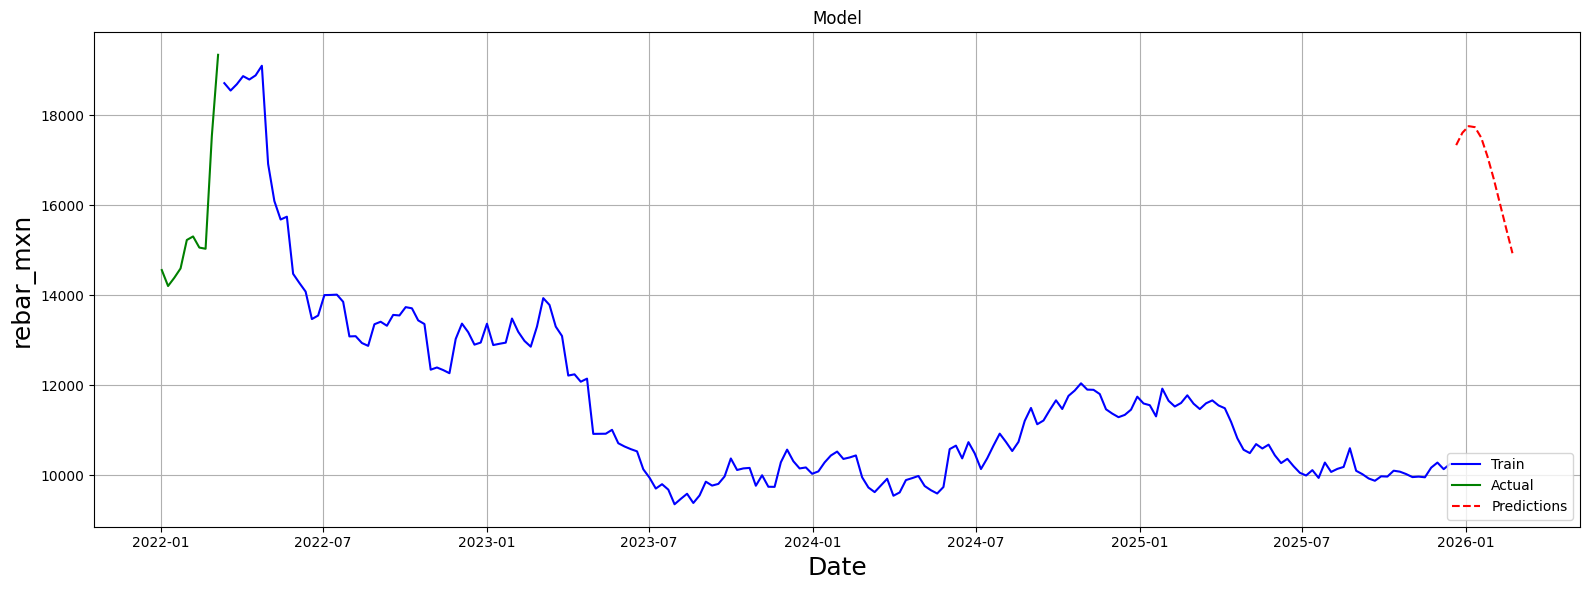


Training data points: 197
Validation data points: 10

First prediction date: 2022-03-06 00:00:00
Last prediction date: 2022-01-02 00:00:00
      id       date  year  scrap   gas  rebar   hrcc1  scrap_mxn   gas_mxn  \
197  263 2022-03-06  2022  629.0  4.73  925.5  1125.0  13146.100   98.8570   
198  264 2022-02-27  2022  645.0  5.02  837.5  1175.0  13506.300  105.1188   
199  265 2022-02-20  2022  504.5  4.47  739.0  1010.0  10261.530   90.9198   
200  266 2022-02-13  2022  505.5  4.43  742.5  1117.0  10251.540   89.8404   
201  267 2022-02-06  2022  515.0  3.94  745.5  1131.0  10572.950   80.8882   
202  268 2022-01-30  2022  502.5  4.57  737.0  1190.0  10381.650   94.4162   
203  269 2022-01-23  2022  470.0  4.64  702.0  1170.0   9771.300   96.4656   
204  270 2022-01-16  2022  474.0  4.00  703.5  1425.0   9693.300   81.8000   
205  271 2022-01-09  2022  467.5  4.26  700.0  1437.0   9485.575   86.4354   
206  272 2022-01-02  2022  467.5  3.92  715.0  1415.0   9518.300   79.8112   

 

In [325]:
from datetime import timedelta
# Plot the data with correct dates
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel(var_analizar, fontsize=18)

last_date = df['date'].max() 
print(last_date)

# Number of predictions you have
n_predictions = len(predictions)

future_dates = []

for i in range(len(predictions)):
    last_date = last_date + timedelta(days=7)  # Weekly predictions, adjust as needed
    future_dates.append(last_date)
print(future_dates)

# print(train['date'])
# print(train[var_analizar])
print(valid['Predictions'])
print(valid['date'])

# Plot training data
plt.plot(train['date'], train[var_analizar], label='Train', color='blue')

# Plot actual validation data
plt.plot(valid['date'], valid[var_analizar], label='Actual', color='green')

# Plot predictions
plt.plot(future_dates, valid['Predictions'], label='Predictions', color='red', linestyle='--')

plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nTraining data points: {len(train)}")
print(f"Validation data points: {len(valid)}")
print(f"\nFirst prediction date: {valid['date'].iloc[0]}")
print(f"Last prediction date: {valid['date'].iloc[-1]}")

print(valid)